# Draft workbook to test plotting functions

Plots to do:
- Basic TS plot
- Seasonal plot + polar!
- Seasonal subseries plot (also box?)
- Scatterplot
- ACF plots

## Imports and setups

In [4]:
import sys
sys.path.append('../')

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from gtime.preprocessing import TimeSeriesPreparation
from gtime.compose import FeatureCreation
from gtime.time_series_models import (
    NaiveForecastModel, 
    SeasonalNaiveForecastModel, 
    AverageForecastModel, 
    DriftForecastModel,
)

## Ploting functions

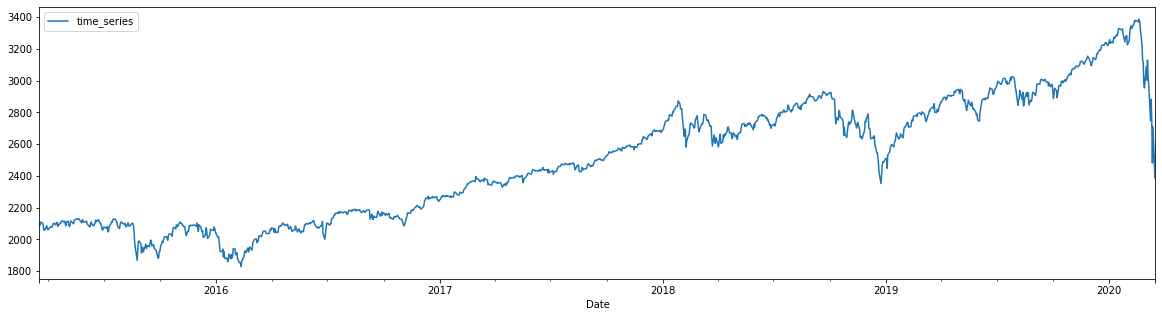

In [747]:
df_sp = pd.read_csv('data/^GSPC.csv')
df_close = df_sp.set_index('Date')['Close']
df_close.index = pd.to_datetime(df_close.index)
time_series_preparation = TimeSeriesPreparation()
period_index_time_series = time_series_preparation.transform(df_close)
period_index_time_series.plot(figsize=(20, 5))
plt.show()

## Time series setup

In [558]:
def autocorr(x, lag):
    x_lag = x[lag:]
    x_1 = x[:-lag]
    cov = np.cov(x_1, x_lag)
    print(cov)
    corr = cov[0, 1] / np.sqrt(cov[1, 1] * cov[0, 0])
    return corr

autocorr(np.array([1, 2, 1, 4]), 1)

[[ 0.33333333 -0.66666667]
 [-0.66666667  2.33333333]]


-0.7559289460184544

In [1118]:
def acf(df, max_lag=10):
    s = pd.DataFrame(np.nan, index=range(1, max_lag + 1), columns=df.columns)
    for i, col in df.iteritems():
        for j in s.index:
            s.loc[j, i] = col.autocorr(j)
    return s
            

In [1144]:
# helper functions

def seasonal_split(df : pd.DataFrame, cycle='year', freq=None, agg='mean'):
    
    if freq is None:
        freq = df.index.freqstr
    df = df.resample(freq).agg(agg)
    
    if isinstance(cycle, str):
        if cycle == 'year':
            df['_Series'] = df.index.start_time.year
            if freq == 'D':
                df['_Season'] = df.index.dayofyear
#             elif freq in ['W-SUN', 'W']:
#                 df['_Season'] = df.index.start_time.weekofyear
            elif freq == 'M':
                df['_Season'] = df.index.month
            elif freq in ['Q', 'Q-DEC']:
                df['_Season'] = df.index.quarter
            else:
                df['_Season'] = df.resample('Y').apply(lambda x: pd.Series(np.arange(1, len(x) + 1))).values
                
        elif cycle == 'quarter':
            df['_Series'] = list(map(lambda x: '_'.join([str(x.year), str(x.quarter)]), df.index))
            df['_Season'] = df.resample('Q').apply(lambda x: pd.Series(np.arange(1, len(x) + 1))).values
            
        elif cycle == 'month':
            df['_Series'] = list(map(lambda x: '_'.join([str(x.year), str(x.month)]), df.index))
            if freq == 'D':
                df['_Season'] = df.index.day
            else:
                df['_Season'] = df.resample('M').apply(lambda x: pd.Series(np.arange(1, len(x) + 1))).values
                
        elif cycle == 'week':
            df['_Series'] = list(map(lambda x: '_'.join([str(x.year), str(x.weekofyear)]), df.index))
            if freq == 'D':
                df['_Season'] = df.index.day
            else:
                df['_Season'] = df.resample('W').apply(lambda x: pd.Series(np.arange(1, len(x) + 1))).values
        else:
            raise ValueError("Incorrect cycle period name")    
    else:
        df['_Series'] = df.resample
        s = []
        for i, j in period_index_time_series.resample(freq):
            s += [i.__str__()] * len(j)
        df['_Season'] = s    
            
    return df.set_index(['_Series', '_Season']).unstack(level=0)
    
seasonal_split(period_index_time_series, 'year', freq='M')

time_series                                                      \
_Series         2015         2016         2017         2018         2019   
_Season                                                                    
1                NaN  1918.597887  2275.115979  2789.803816  2607.389997   
2                NaN  1904.418494  2329.910542  2705.155248  2754.864206   
3        2082.513989  2021.954090  2366.822170  2702.773821  2803.983794   
4        2094.862840  2075.535232  2359.309455  2653.625209  2903.799979   
5        2111.943518  2065.550479  2395.345881  2701.493619  2854.705910   
6        2099.283658  2083.891368  2433.985451  2754.352888  2890.165979   
7        2094.143627  2148.901978  2454.102502  2793.643357  2996.113636   
8        2039.866205  2177.482167  2456.223070  2857.820429  2897.450451   
9        1944.402384  2157.690965  2492.841040  2901.500514  2982.156006   
10       2024.812716  2143.020938  2556.997270  2785.464780  2977.675198   
11       2080.616504  2164.985689  2593.605736  2723.231422  3104.904492   
12       2054.079562  2246.629046  2664.340527  2567.307386  3176.749512   

                      
_Series         2020  
_Season               
1        3278.202858  
2        3277.314183  
3        2808.098328  
4                NaN  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                NaN  
10               NaN  
11               NaN  
12               NaN

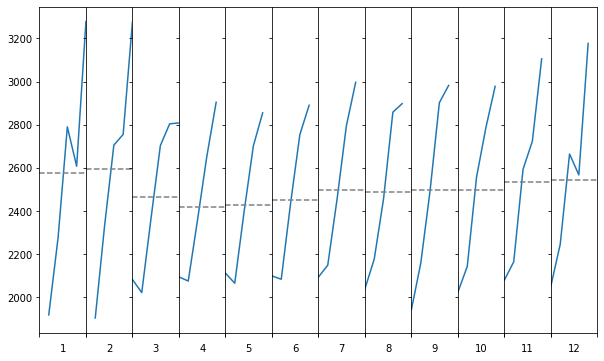

In [1142]:

def subplots(df: pd.DataFrame, cycle, freq=None, agg='mean'):
    ss = seasonal_split(df, cycle, freq, agg)
    fig, ax = plt.subplots(ss.columns.levshape[0], ss.shape[0], 
                           sharey=True, figsize=(10, 6), squeeze=False, 
                           gridspec_kw={'wspace':0})
    i = 0
    for _, table in ss.groupby(level=0, axis=1):
        j = 0
        for _, col in table.iterrows():
            axes = ax[i, j]
            col.plot(ax=axes)
            mean = col.mean()
            axes.axhline(mean, color='gray', linestyle='--')
            axes.set(xlabel=col.name)
            axes.set_xticklabels([])
            j += 1
        i += 1
    plt.show()

subplots(period_index_time_series, 'year', 'M')    

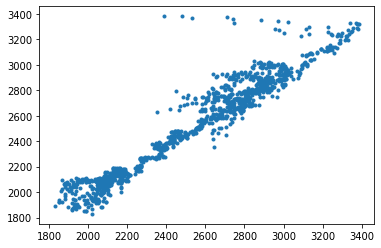

In [1056]:
plt.plot(period_index_time_series, period_index_time_series.shift(20), '.')

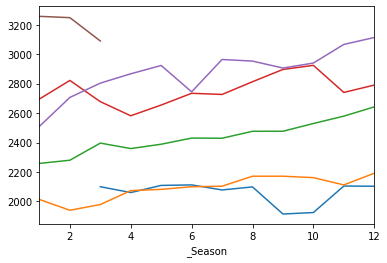

In [1094]:
def plot_fun(df, ax=None):
    if ax is None:
        ax = df.plot(legend=False)
    else:
        df.plot(ax=ax, legend=False)
    return ax

def basic_ts(df, ax=None):
    ax = plot_fun(df, ax)
    return ax

def polar_ts(df, ax=None):
    df = df.append(df.iloc[0])
    if ax is None:
        ax = plt.subplot(111, projection='polar')
    angles = [x * 360 / (len(df) - 1) for x in range(len(df))]
    theta = [x / 360 * 2 * np.pi for x in angles]
    for col in df.columns:
        plt.polar(theta, df[col], scalex=False)
    ax.set_thetagrids(angles=angles)
    ax.set_xticklabels(df.index)
    return ax

def season_ts(df: pd.DataFrame, cycle, freq=None, polar=False, ax=None):
    df_seas = seasonal_split(df, cycle, freq)
    if polar:
        ax = polar_ts(df_seas, ax=ax)
    else:
        ax = basic_ts(df_seas, ax=ax)
#         if isinstance(cycle, str):
#             ax.set_xlabel(str(freq) + ' of ' + cycle)
    return ax

season_ts(period_index_time_series.resample('M').first().fillna(method='ffill'), 'year', polar=False)

## Tests

/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/semyonburyachenko/Documents/Upwork/Giotto/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start 

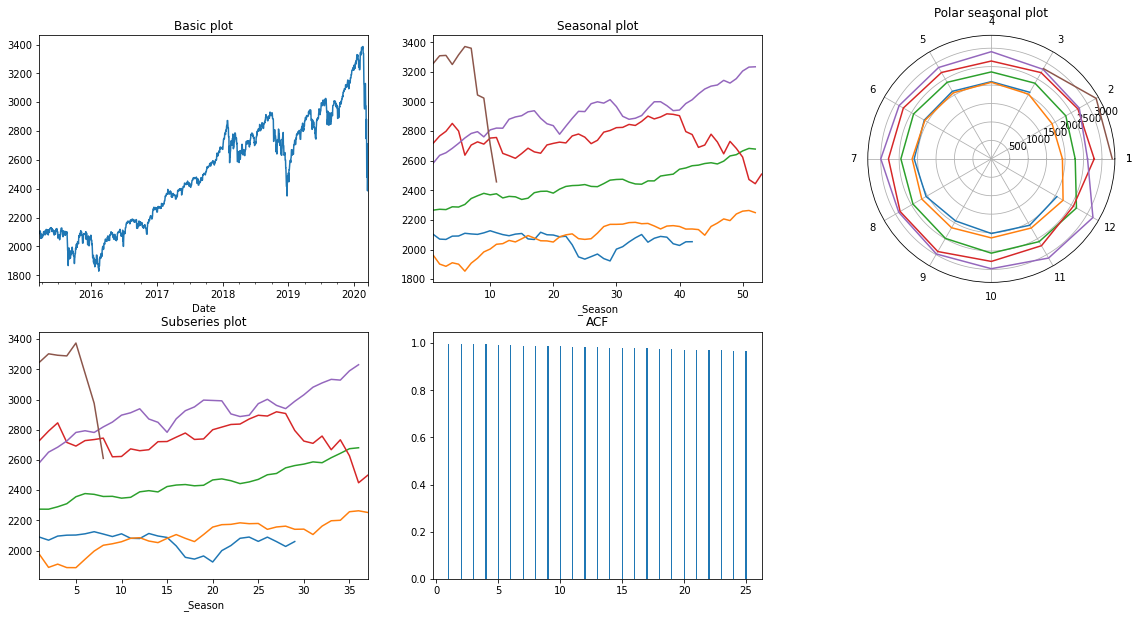

In [1161]:
# Show
ddf = period_index_time_series.resample('D').fillna(method='ffill')
fig = plt.figure(figsize=(20, 10))
a = fig.add_subplot(231, title='Basic plot')
basic_ts(ddf, ax=a)
b = fig.add_subplot(232, title='Seasonal plot')
season_ts(ddf, 'year', freq='W', ax=b)
c = fig.add_subplot(233, projection='polar')
season_ts(ddf, 'year', freq='M', ax=c, polar=True)
c.set_title('Polar seasonal plot')
d = fig.add_subplot(234, title='Subseries plot')
season_ts(ddf, 'year', pd.Timedelta(10, 'D'), ax=d)

# subplots(period_index_time_series, 'year', 'M', ax=d) 
f = fig.add_subplot(235, title='ACF')
y = acf(ddf, max_lag=25)
f.bar(y.index, np.squeeze(y.values), 0.1)

plt.show()

In [1104]:
e.bar(range(3), [2, 3, 4])
plt.show()

<BarContainer object of 25 artists>

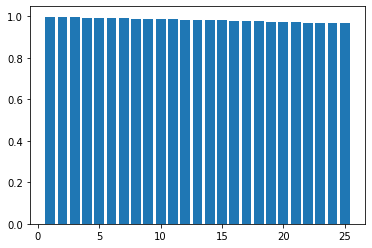

In [1120]:
plt.bar(x=y.index, height=np.squeeze(y.values))

In [1121]:
y

,time_series
1,0.998162
2,0.996933
3,0.995770
4,0.994346
5,0.992751
6,0.991166
7,0.989763
8,0.988377
9,0.987118
10,0.985971
